Dataset shape: (4, 1320, 1000)


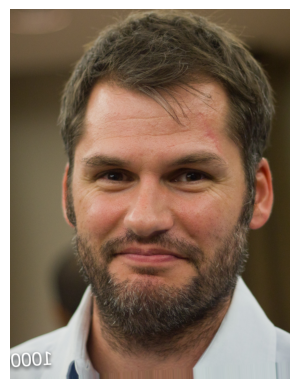

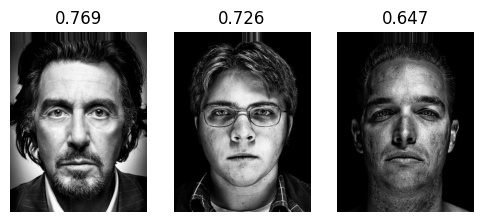

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd


noOfLevels=6

def lapStack(inputImg):
    h,w=np.shape(inputImg)
    lapStack=np.empty((h,w,noOfLevels))

    lap=[]
    for i in range(0,noOfLevels):
        sigma2 = 2**(i+1)
        ksize2 = 6*sigma2-1
        
        gaBlur2=cv2.GaussianBlur(inputImg.copy(),(ksize2,ksize2),sigma2,sigma2)
        if(i==0):
            lap.append(inputImg-gaBlur2)
        else:
            sigma1 = 2**i
            ksize1 = 6*sigma1-1
            gaBlur1=cv2.GaussianBlur(inputImg.copy(),(ksize1,ksize1),sigma1,sigma1)
            lap.append(gaBlur1-gaBlur2)
            if(i== noOfLevels-1):
                lap.append(gaBlur2)
    return lap

def localEnergyStack(gausStack):
    S=[]
    #gausStack=np.array(gausStack)
    #gausStackSq=np.square(gausStack)
    gausStackSq=[i**2 for i in gausStack]
    
    for i in range(noOfLevels):
        sigma=2**(i+1)
        # c=0
        # if ((5*sigma)%2==0):c=1
        # # S.append(cv2.GaussianBlur(gausStackSq[i],(5*sigma+c,5*sigma+c),sigma,sigma))
        S.append(np.array(cv2.GaussianBlur(gausStackSq[i],(6*sigma-1,6*sigma-1),sigma,sigma)).flatten())
    
    return np.array(S,dtype=object)

def norm_cross_corr(inputImg,refImg):
    lapIn=lapStack(inputImg)
    lapRef=lapStack(refImg)

    Si=localEnergyStack(lapIn)
    Sr=localEnergyStack(lapRef)
    
    x = len(Si)
    y = len(Si[0])
    
    corr = np.sum(np.multiply(Si,Sr))
    corrinp = np.sum((Si)**2)
    corrref = np.sum((Sr)**2)
    out = (corr)/((corrinp*corrref)**0.5)

    return out

def plot(images,indices,out):
    #indices = [randrange(100)+1 for i in range(5)]
    plt.figure(figsize=(25,25))
    for c,i in enumerate(indices):
        ele = images[i]
        minim = np.min(ele)
        maxim = np.max(ele)
        ele = (ele - minim) / (maxim - minim)
        ele = np.clip(ele,0,254)
        plt.subplot(1,12,c+1)
        plt.axis('off')
        plt.imshow(ele,cmap=plt.cm.gray)
        plt.title(str(round(out[i],3)))
    plt.show()
    
def load_data(dir_path):
    image_list = []
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = cv2.imread(os.path.join(dir_path,filename),0) 
            image_list.append(im)
        else:
            continue
    image_list = np.array(image_list)
    print("Dataset shape:",image_list.shape)
    return image_list
    

imgdata = load_data("../data/inputs/examples/fgs")
# imgrgb = cv2.imread("../data/inputs/examples/0006_001.png")
# imgrgb = cv2.imread("../data/inputs/examples/0008_002.png")
# imgrgb = cv2.imread("../data/inputs/examples/6146621199_393b622aa2_o.png")
imgrgb = cv2.imread("../data/inputs/examples/6431431783_2b07a4f6fa_o.png")

imggray = cv2.cvtColor(imgrgb, cv2.COLOR_BGR2GRAY)
l = len(imgdata)
out = np.empty(l)
for i in range(l):
    nccrf = norm_cross_corr(imggray,np.array(imgdata[i]))
    out[i] = nccrf

ind = np.argsort(out*-1)
reqind = ind[:3]
plt.axis('off')
plt.imshow(imgrgb[:,:,::-1])
plot(imgdata,reqind, out)
